In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 15, 8

In [3]:
raw_data = 'drive/My Drive/Datasets/household_power_consumption.txt'

In [4]:
dataset = pd.read_csv(raw_data, sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [5]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
# Change NaNs from ?
dataset.replace('?', np.nan, inplace=True)

In [7]:
# add a column for for the remainder of sub metering
values = dataset.values.astype('float32')
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

In [8]:
clean_df = dataset.copy()

In [9]:
clean_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0,71.800003
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0,43.099998


In [10]:
clean_df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
sub_metering_4           25979
dtype: int64

I find this extremely weird...

In [13]:
new_file = 'drive/My Drive/Datasets/clean_household_power_consumption.csv'

In [14]:
df = pd.read_csv(new_file, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

In [15]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [16]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
sub_metering_4           25979
dtype: int64

In [17]:
no_nan_df = df.fillna(df.mean())

In [18]:
no_nan_df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
dtype: int64

In [19]:
no_nan_df.shape

(2075259, 8)

In [20]:
#downsample to daily -> we are interested in total cosumption so we want the daily sum aggregates

daily_df = no_nan_df.resample('D').sum()

In [21]:
daily_df.shape

(1442, 8)

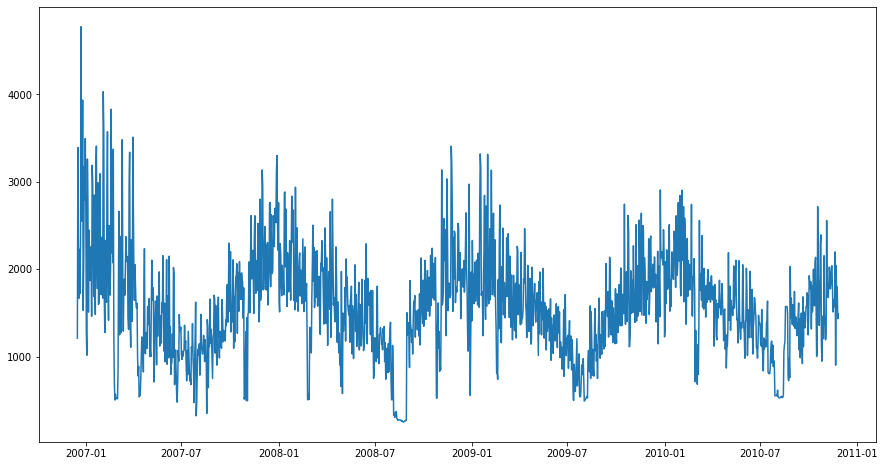

In [23]:
plt.plot(daily_df.index.values, daily_df.Global_active_power.values)

In [25]:
from scipy.stats import pearsonr

In [30]:
corr, _ = pearsonr(no_nan_df.Global_active_power, no_nan_df.Global_reactive_power)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.247


In [31]:
#pearson correlation coefficient...

no_nan_df.corr()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
Global_active_power,1.000000,0.247017,-0.399762,0.998889,0.484401,0.434569,0.638555,0.701380
Global_reactive_power,0.247017,1.000000,-0.112246,0.266120,0.123111,0.139231,0.089617,0.211624
Voltage,-0.399762,-0.112246,1.000000,-0.411363,-0.195976,-0.167405,-0.268172,-0.271371
Global_intensity,0.998889,0.266120,-0.411363,1.000000,0.489298,0.440347,0.626543,0.703258
Sub_metering_1,0.484401,0.123111,-0.195976,0.489298,1.000000,0.054721,0.102571,0.125067
Sub_metering_2,0.434569,0.139231,-0.167405,0.440347,0.054721,1.000000,0.080872,0.085201
Sub_metering_3,0.638555,0.089617,-0.268172,0.626543,0.102571,0.080872,1.000000,0.178724
sub_metering_4,0.701380,0.211624,-0.271371,0.703258,0.125067,0.085201,0.178724,1.000000


The pearson coefficient between Global_active_power and Global_reactive_power is 0.041098



The pearson coefficient between Voltage and Global_intensity is 0.052267


# Facebook Prophet

In [58]:
daily_df_pr = daily_df.reset_index()

In [59]:
daily_df_pr.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


In [60]:
train, test = daily_df_pr.iloc[0:-365, :], daily_df_pr.iloc[-365:, :]

In [61]:
train.shape

(1077, 9)

In [62]:
test.shape

(365, 9)

In [63]:
daily_df.shape

(1442, 8)

In [64]:
from fbprophet import Prophet

In [65]:
train.rename(columns={"datetime":"ds", "Global_active_power":"y"}, inplace=True)
test.rename(columns={"datetime":"ds", "Global_active_power":"y"}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [66]:
train.head()

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


In [67]:
train = train[['ds', 'y']].copy()
test = test[['ds', 'y']].copy()

In [68]:
model = Prophet()
model.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [69]:
# Forecasting for the next 365 days
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,1651.925107,1842.826189,2992.597183,1651.925107,1651.925107,775.704922,775.704922,775.704922,245.779609,245.779609,245.779609,529.925314,529.925314,529.925314,0.0,0.0,0.0,2427.630030
1,2006-12-17,1651.750694,1869.405325,2983.749157,1651.750694,1651.750694,772.518540,772.518540,772.518540,228.485697,228.485697,228.485697,544.032843,544.032843,544.032843,0.0,0.0,0.0,2424.269234
2,2006-12-18,1651.576280,1472.543556,2606.990567,1651.576280,1651.576280,397.708006,397.708006,397.708006,-161.258234,-161.258234,-161.258234,558.966240,558.966240,558.966240,0.0,0.0,0.0,2049.284287
3,2006-12-19,1651.401867,1667.935183,2772.193834,1651.401867,1651.401867,544.953093,544.953093,544.953093,-29.330130,-29.330130,-29.330130,574.283223,574.283223,574.283223,0.0,0.0,0.0,2196.354960
4,2006-12-20,1651.227453,1699.581994,2804.118068,1651.227453,1651.227453,564.813274,564.813274,564.813274,-24.712366,-24.712366,-24.712366,589.525641,589.525641,589.525641,0.0,0.0,0.0,2216.040728


In [70]:
forecast.shape

(1442, 19)

In [71]:
y_test = test['y'].copy()

In [75]:
y_hat = forecast.iloc[-365:, :]
y_hat = y_hat['yhat']

In [79]:
assert y_test.shape[0] == y_hat.shape[0]

In [80]:
np.mean(np.abs((y_test-y_hat)/y_test)) * 100

20.884985090046296

In [81]:
np.sqrt(np.mean((y_test - y_hat)**2))

374.9533926990719

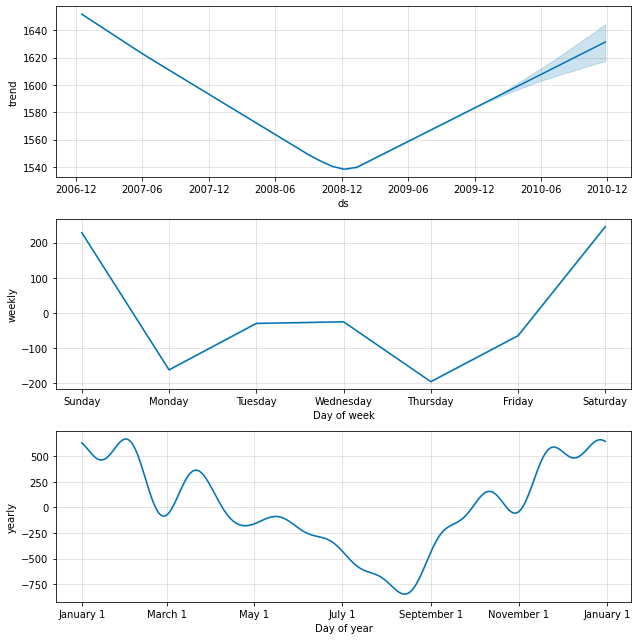

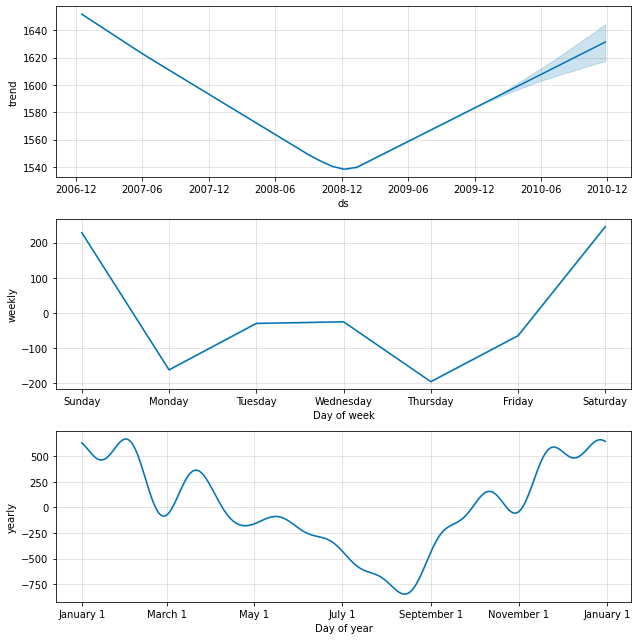

In [82]:
model.plot_components(forecast)

In [ ]:
train, test = daily_df_pr.iloc[0:-365, :], daily_df_pr.iloc[-365:, :]

train.rename(columns={"datetime":"ds", "Global_active_power":"y", "Global_reactive_power":'add_1',	"Voltage":'add_2',	"Global_intensity":"add_3",	"Sub_metering_1":"add_4",	"Sub_metering_2":"add_5",	"Sub_metering_3":"add_6"}, inplace=True)
test.rename(columns={"datetime":"ds", "Global_active_power":"y", "Global_reactive_power":'add_1',	"Voltage":'add_2',	"Global_intensity":"add_3",	"Sub_metering_1":"add_4",	"Sub_metering_2":"add_5",	"Sub_metering_3":"add_6"}, inplace=True)

In [85]:
train.head()

,ds,y,add_1,add_2,add_3,add_4,add_5,add_6,sub_metering_4
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0,14680.933319
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0,36946.666732
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0,19028.433281
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0,13131.900043
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0,20384.800011


In [86]:
train = train.drop('sub_metering_4', axis=1)
test = test.drop('sub_metering_4', axis=1)

In [87]:
model2 = Prophet()
model2.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [88]:
# Forecasting for the next 365 days
future = model2.make_future_dataframe(periods=365, freq='D')
forecast = model2.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,1651.925107,1867.800151,2993.261166,1651.925107,1651.925107,775.704922,775.704922,775.704922,245.779609,245.779609,245.779609,529.925314,529.925314,529.925314,0.0,0.0,0.0,2427.630030
1,2006-12-17,1651.750694,1910.853742,2994.598662,1651.750694,1651.750694,772.518540,772.518540,772.518540,228.485697,228.485697,228.485697,544.032843,544.032843,544.032843,0.0,0.0,0.0,2424.269234
2,2006-12-18,1651.576280,1465.088584,2632.541020,1651.576280,1651.576280,397.708006,397.708006,397.708006,-161.258234,-161.258234,-161.258234,558.966240,558.966240,558.966240,0.0,0.0,0.0,2049.284287
3,2006-12-19,1651.401867,1616.445234,2736.757580,1651.401867,1651.401867,544.953093,544.953093,544.953093,-29.330130,-29.330130,-29.330130,574.283223,574.283223,574.283223,0.0,0.0,0.0,2196.354960
4,2006-12-20,1651.227453,1663.435423,2777.434469,1651.227453,1651.227453,564.813274,564.813274,564.813274,-24.712366,-24.712366,-24.712366,589.525641,589.525641,589.525641,0.0,0.0,0.0,2216.040728


In [89]:
y_test = test['y'].copy()
y_hat = forecast.iloc[-365:, :]
y_hat = y_hat['yhat']

In [90]:
assert y_test.shape[0] == y_hat.shape[0]

In [91]:
np.mean(np.abs((y_test-y_hat)/y_test)) * 100

20.884985090046296

In [92]:
np.sqrt(np.mean((y_test - y_hat)**2))

374.9533926990719

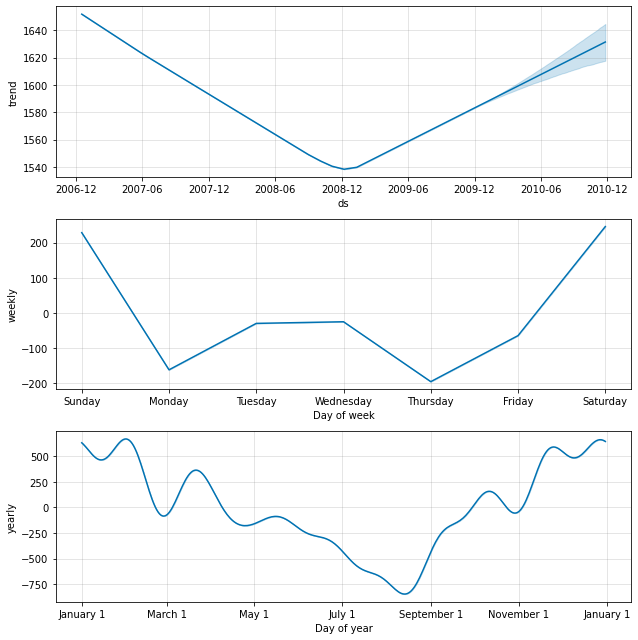

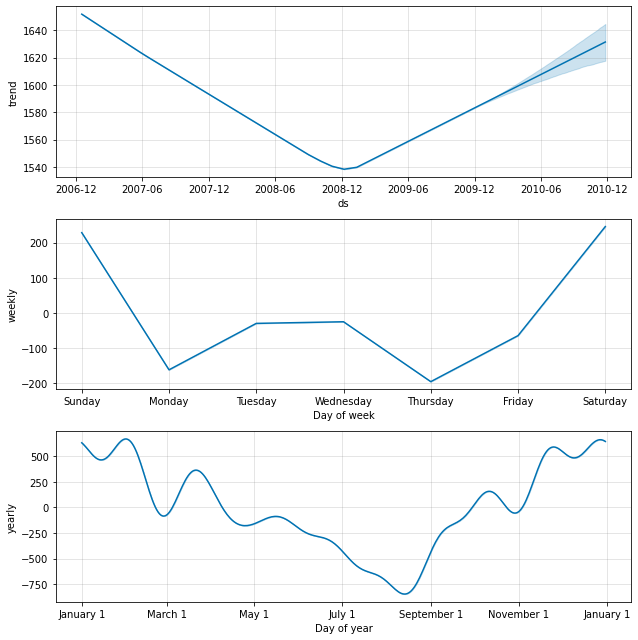

In [93]:
model2.plot_components(forecast)